In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import scipy
import os

In [9]:
def load_data(img_path, msk_path, describe=True):
    img = np.load(img_path)['data']
    # only necessary if input is not already in an (x,y,z) format
    #img = img.transpose(1,2,0)
    if os.path.splitext(msk_path.split('/')[-1])[0] == 'labels_train':
        msk = np.load(msk_path)['labels']
        #msk = msk.transpose(1,2,0)
    if os.path.splitext(msk_path.split('/')[-1])[0] == 'boundaries':
        msk = np.load(msk_path)['boundaries']

    
    if describe:
        print(f'Image Shape: {img.shape} -- Image Min/Max: {(np.min(img), np.max(img))}')
        print(f'Mask Shape: {msk.shape} -- Mask Min/Max: {(np.min(msk), np.max(msk))}')
    
    return img, msk

#dataset_path = '/home/seam_team_six/data/npz original/'


#data_path = os.path.join(dataset_path, 'data_train.npz')
#labels_path = os.path.join(dataset_path, 'labels_train.npz')
dataset_all,labels_all = load_data(data_path, labels_path, describe = True)
dataset = dataset_all[:dataset_all.shape[0]-int(dataset_all.shape[0]*(test_size)),:,:]
labels = labels_all[:labels_all.shape[0]-int(labels_all.shape[0]*(test_size)),:,:]

Image Shape: (777, 590, 1006) -- Image Min/Max: (-5195.5234, 5151.7188)
Mask Shape: (777, 590, 1006) -- Mask Min/Max: (1, 6)


In [3]:
data = dataset
print(data.shape)

(150, 150, 1006)


In [4]:
# Decrement masks values by 1 to stay consistent with 0 indexing in python.
labels = labels - 1
print(f'Labels min: {np.min(labels)} -- Labels max: {np.max(labels)}')

Labels min: 0 -- Labels max: 5


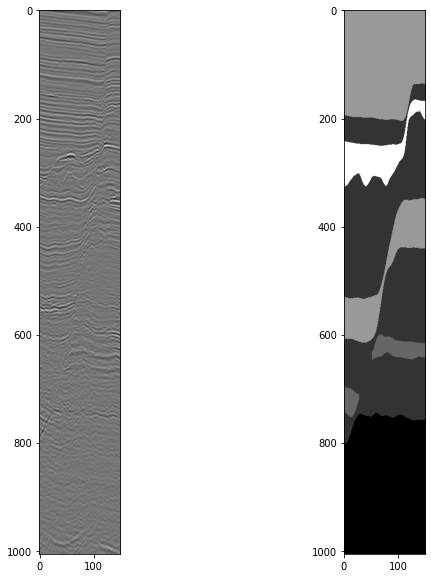

In [5]:
# Plot 2D slices of images and ground truth.
#image_slice = np.transpose(data,(2,0,1))[:,10,:]
#mask_slice = np.transpose(labels,(2,0,1))[:,10,:]
#fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,10))
#axs[0].imshow(image_slice, cmap='gray')
#axs[1].imshow(mask_slice, cmap='gray')

In [7]:
def normalize_image_intensity(img):
    return (img - np.min(img))/(np.max(img) - np.min(img))

# Test normalizing function.
image_slice = data[:,:,20]
normalized_image = normalize_image_intensity(image_slice)
print(f'Min data value (regular): {np.min(image_slice)} -- Max data value (regular): {np.max(image_slice)}')
print(f'Min data value (normalized): {np.min(normalized_image)} -- Max data value (normalized): {np.max(normalized_image)}')

Min data value (regular): -740.005615234375 -- Max data value (regular): 930.132568359375
Min data value (normalized): 0.0 -- Max data value (normalized): 1.0


In [8]:
# Normalize volume.
data = normalize_image_intensity(data)
print(f'Min data value (normalized): {np.min(data)} -- Max data value (normalized): {np.max(data)}')

Min data value (normalized): 0.0 -- Max data value (normalized): 1.0


In [4]:
#import numpy as np
#depthData = np.empty(data.shape)
#depthData = np.empty((10,10,10))
#for z in range(depthData.shape[2]):
    #depthData[:,:,z] = z

NameError: name 'data' is not defined

In [ ]:
# append depth info
#data = np.stack((data,depthData),axis=-1)
#data = [tf.expand_dims(x, axis=3) for x in data]
#print(data.shape)

In [12]:
import random

def random_vol_pick(img, msk, vol_num, vol_size=(64,64,64)):
    pickedData = []
    pickedLabels = []
    pickedLocations = []
    pickedPopularity = [0,0,0,0,0,0]
    for i in range(vol_num):
        searching = True
        while searching:
            coords = []
            for j in range(3): #each axis
                randomNum = random.randint(0+vol_size[j]//2, img.shape[j]-vol_size[j]//2)
                coords.append(randomNum)
            pickedLocations.append(coords)
            dataCube = img[coords[0]-vol_size[0]//2:coords[0]+vol_size[0]//2, coords[1]-vol_size[1]//2:coords[1]+vol_size[1]//2, coords[2]-vol_size[2]//2:coords[2]+vol_size[2]//2]
            labelCube = msk[coords[0]-vol_size[0]//2:coords[0]+vol_size[0]//2, coords[1]-vol_size[1]//2:coords[1]+vol_size[1]//2, coords[2]-vol_size[2]//2:coords[2]+vol_size[2]//2]

            unique, counts = np.unique(labelCube, return_counts=True)
            popular = int(unique[np.argmax(counts,axis=-1)])
            #print(f'{popular} {pickedPopularity[popular]}')
            if pickedPopularity[popular] < max(pickedPopularity) or pickedPopularity[popular]==min(pickedPopularity):
                pickedPopularity[int(unique[np.argmax(counts,axis=-1)])]+=1
                searching = False
                #print(f'{popular} {pickedPopularity[popular]}')
            else:
                del dataCube, labelCube
        #dict(zip(unique, counts))
        if i%10==0:
            print(pickedPopularity)
        pickedData.append(dataCube[0:vol_size[0],0:vol_size[1],0:vol_size[2]])
        pickedLabels.append(labelCube[0:vol_size[0],0:vol_size[1],0:vol_size[2]])
        
        del dataCube, labelCube
        
    print(pickedPopularity)
    
    return pickedData, pickedLabels

In [17]:
# Test create_volumes_pipeline function.
sliced_data, sliced_mask = random_vol_pick(data,labels,box_num,vol_size=box_size)

Samples in X, Y, Z: (2, 2, 15)
Shapes in X1, Y1, Z1: (64, 64, 64)
Total volume samples: 60
Data shape after slicing: (64, 64, 64)
Total volume samples (Similarity test): 60


In [29]:
# Free up space.#
del data; del labels

In [19]:
# Check sliced volume sizes and make sure they have the same dimensions.
def check_dimensions(img, msk, shape=box_size, remove=True):
    test_array = np.zeros(shape)
    new_img, new_msk = img, msk
    if remove:
        new_img = [x for x in new_img if (x.shape == test_array.shape)]
        new_msk = [x for x in new_msk if (x.shape == test_array.shape)]

    print(f'{len(img) - len(new_img)} volumes removed due to incorrect dimensions.')
    return new_img, new_msk
        
# Remove any data that have dimensions not matching input size.
#input_data, input_masks = check_dimensions(sliced_data, sliced_mask)

0 volumes removed due to incorrect dimensions.


In [ ]:
input_data, input_masks = sliced_data, sliced_mask